<a href="https://colab.research.google.com/github/Boyinglby/ADL_lab/blob/main/DL_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

# Load and preprocess data

In [2]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = pd.concat([df_, pd.DataFrame({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, index = [row['index']])],ignore_index=True)
    return df_

In [3]:
# get data, pre-process and split
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']

In [4]:
# Import the NLTK library
import nltk
nltk.download('punkt')
nltk.download('stopwords')
data = preprocess_pandas(data, columns)                             # pre-process


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
training_data_r, validation_data_r, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )

In [20]:
# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data_r)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch

vocab_size = len(word_vectorizer.vocabulary_)

validation_data = word_vectorizer.transform(validation_data_r)
validation_data = validation_data.todense()

train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()

validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

# LSTM model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

out_nr = 2

class LSTM(nn.Module):
    def __init__(self, hidden_size = 25):
        super(LSTM, self).__init__()
        num_layers = 1
        # Recurrent layer
        # TODO:
        self.lstm = nn.LSTM(input_size=vocab_size,
                         hidden_size=hidden_size,
                         num_layers=num_layers,
                         bidirectional=False)

        # Output layer
        self.l_out = nn.Linear(in_features=hidden_size,
                            out_features=out_nr,
                            bias=False)

    def forward(self, x):
        # RNN returns output and last hidden state
        # TODO:
        x, (h, c) = self.lstm(x)

        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)

        # Output layer
        # TODO:
        x = self.l_out(x)

        return x

In [8]:
# Initialise our network
model = LSTM()
print(model)
min_LSTM_loss = 10000

# Store training and validation loss
training_loss, validation_loss = [], []

# Define a loss function and optimizer for this problem
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
# A way to get learning rate decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

LSTM(
  (lstm): LSTM(5145, 25)
  (l_out): Linear(in_features=25, out_features=2, bias=False)
)


In [9]:
# one hot encode label
to_onehot = nn.Embedding(1, 2)
to_onehot.weight.data = torch.eye(2)

In [ ]:
# Hyper-parameters
num_epochs = 5

import matplotlib.pyplot as plt
%matplotlib inline

# For each epoch
for i in range(num_epochs):

    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0

    model.eval()

    # For each sentence in validation set
    for i in range(len(validation_x_tensor)):

        # Forward pass

        outputs = model.forward(validation_x_tensor[i].reshape(1,vocab_size))
        # Compute loss
        loss = criterion(outputs[0], to_onehot(validation_y_tensor[i]))

        if loss<min_LSTM_loss:
            torch.save(model, 'best_model.pt')

        # Update loss
        epoch_validation_loss += loss.detach().numpy()

    model.train()

    # For each sentence in training set
    for j in range(len(train_x_tensor)):

        # Forward pass
        outputs = model.forward(train_x_tensor[j].reshape(1,vocab_size))

        # Compute loss
        # TODO:
        loss = criterion(outputs[0], to_onehot(train_y_tensor[j]))

        # Reset gradients
        # TODO:
        optimizer.zero_grad()
        # Compute gradients
        # TODO:
        loss.backward()
        # Update weights
        # TODO:
        optimizer.step()

        # Update learning rate (advanced technique, can be ignored)
        scheduler.step()

        # Update loss
        epoch_training_loss += loss.detach().numpy()

    # Save loss for plot
    training_loss.append(epoch_training_loss/len(train_x_tensor))
    validation_loss.append(epoch_validation_loss/len(validation_x_tensor))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

# Plot training and validation loss
epoch = np.arange(len(training_loss))

# Forward pass
# TODO:
best_model = LSTM()
best_model = torch.load('best_model.pt')

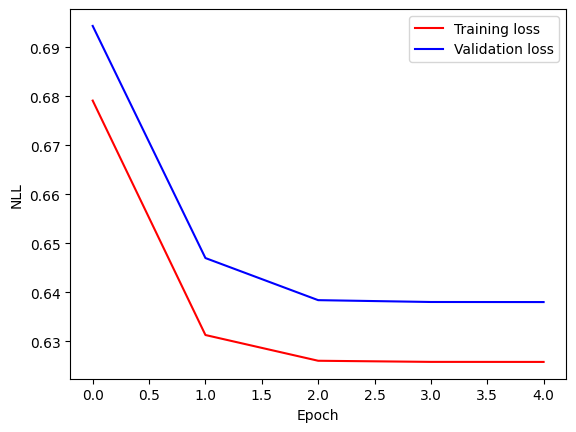

In [16]:
# plot loss curve
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [21]:
# Get first sentence in validation set
inputs, targets = validation_x_tensor[0], validation_y_tensor[0]
outputs = best_model.forward(inputs.reshape(1,vocab_size)).data.numpy()

print('\nInput sequence:')
print(validation_data_r[0])

print('\nTarget sequence:')
print(targets)

preds = np.argmax(outputs)
print('\nPredicted sequence:')
print(preds)


Input sequence:
disappointed .

Target sequence:
tensor(0)

Predicted sequence:
0
